In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score,recall_score






In [3]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Function to load image paths and labels
def load_data_paths_labels(base_dir):
    image_paths, labels = [], []
    for category in ['Normal', 'Non-COVID']:
        category_dir = os.path.join(base_dir, category, 'images')
        for img_name in os.listdir(category_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')) and not img_name.startswith('.'):
                image_paths.append(os.path.join(category_dir, img_name))
                labels.append(0 if category == 'Normal' else 1)
    return image_paths, labels

# Loading data paths and labels
train_image_paths, train_labels = load_data_paths_labels('/content/drive/MyDrive/FYP/Dataset/Classification/Train')
val_image_paths, val_labels = load_data_paths_labels('/content/drive/MyDrive/FYP/Dataset/Classification/Val')
test_image_paths, test_labels = load_data_paths_labels('/content/drive/MyDrive/FYP/Dataset/Classification/Test')

# Convert to DataFrame for flow_from_dataframe
train_df = pd.DataFrame({'filename': train_image_paths, 'category': train_labels})
val_df = pd.DataFrame({'filename': val_image_paths, 'category': val_labels})
test_df = pd.DataFrame({'filename': test_image_paths, 'category': test_labels})

# Convert 'category' to string labels
train_df['category'] = train_df['category'].astype(str)
val_df['category'] = val_df['category'].astype(str)
test_df['category'] = test_df['category'].astype(str)

In [ ]:
import os

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


def load_data_paths_labels_with_error_handling(base_dir):
    """
    Loads image paths and labels from a directory structure, handling embedded null characters in paths.

    Args:
        base_dir (str): Path to the base directory containing subdirectories for each class.

    Returns:
        tuple: A tuple containing two NumPy arrays: image paths and labels.

    Raises:
        ValueError: If an error is encountered while processing files or if no images are found.
    """

    image_paths = []
    labels = []

    for category in ['Normal', 'Non-COVID']:
        category_dir = os.path.join(base_dir, category, 'images')

        # Filter out any hidden files or directories with null characters
        filtered_files = [f for f in os.listdir(category_dir)
                          if not f.startswith('.') and '\0' not in f]

        if not filtered_files:
            raise ValueError(f"No images found in directory '{category_dir}'")

        for img_name in filtered_files:
            image_path = os.path.join(category_dir, img_name)
            image_paths.append(image_path)
            labels.append(0 if category == 'Normal' else 1)

    return np.array(image_paths), np.array(labels)

# Example usage with error handling
try:
    train_image_paths, train_labels = load_data_paths_labels_with_error_handling('/content/drive/MyDrive/Final Year Project/FYP_Implemention/Dataset/Classification Data/Train')
    val_image_paths, val_labels = load_data_paths_labels_with_error_handling('/content/drive/MyDrive/Final Year Project/FYP_Implemention/Dataset/Classification Data/Val')
except ValueError as e:
    print(f"Error loading data: {e}")
    # Handle the error gracefully, e.g., exit or retry with a different path


In [ ]:


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)

# Function to load image paths and labels
def load_data_paths_labels(base_dir):
    image_paths = []
    labels = []  # 0 for Normal, 1 for Non-COVID (Pneumonia)

    for category in ['Normal', 'Non-COVID']:
        category_dir = os.path.join(base_dir, category, 'images')
        for img_name in os.listdir(category_dir):
            if img_name.startswith('.'):  # Skip hidden files
                continue
            image_paths.append(os.path.join(category_dir, img_name))
            labels.append(0 if category == 'Normal' else 1)

    return np.array(image_paths), np.array(labels)

train_image_paths,train_labels = load_data_paths_labels('/content/drive/MyDrive/FYP/Dataset/Classification/Train')

val_image_paths,val_labels = load_data_paths_labels('/content/drive/MyDrive/FYP/Dataset/Classification/Val')
test_image_paths,test_labels = load_data_paths_labels('/content/drive/MyDrive/FYP/Dataset/Classification/Train')

all_data = np.concatenate((train_image_paths, val_image_paths), axis=0)
all_labels = np.concatenate((train_labels, val_labels), axis=0)



In [4]:
def custom_build_model():

  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
  for layer in base_model.layers:
    layer.trainable = False

  x = base_model.output
  x = Flatten()(x)  # Flatten the output of the base model
  x = Dense(512, activation='relu')(x)  # Add a fully-connected layer
  x = Dropout(0.5)(x)  # Add dropout for regularization
  predictions = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=predictions)
  return model

In [5]:
model = custom_build_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [6]:
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size,
    prefetch=2,

)

val_generator = test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size
)

# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/FYP/Implemention/new_vgg16_pneumonia_detection.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
callbacks_list = [checkpoint, early_stopping, reduce_lr]

Found 14057 validated image filenames belonging to 2 classes.
Found 3514 validated image filenames belonging to 2 classes.


In [8]:
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=4,
    max_queue_size=10,
    callbacks=callbacks_list,
    verbose=1

)


Epoch 1/10
440/440 [==============================] - ETA: 0s - loss: 0.5647 - accuracy: 0.7009
Epoch 1: val_accuracy improved from -inf to 0.78002, saving model to /content/drive/MyDrive/FYP/Implemention/new_vgg16_pneumonia_detection.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


440/440 [==============================] - 1573s 4s/step - loss: 0.5647 - accuracy: 0.7009 - val_loss: 0.4477 - val_accuracy: 0.7800 - lr: 1.0000e-04
Epoch 2/10
440/440 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.7514
Epoch 2: val_accuracy did not improve from 0.78002
440/440 [==============================] - 261s 590ms/step - loss: 0.5056 - accuracy: 0.7514 - val_loss: 0.4575 - val_accuracy: 0.7777 - lr: 1.0000e-04
Epoch 3/10
440/440 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.7677
Epoch 3: val_accuracy improved from 0.78002 to 0.81673, saving model to /content/drive/MyDrive/FYP/Implemention/new_vgg16_pneumonia_detection.h5
440/440 [==============================] - 273s 616ms/step - loss: 0.4879 - accuracy: 0.7677 - val_loss: 0.4071 - val_accuracy: 0.8167 - lr: 1.0000e-04
Epoch 4/10
440/440 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.7711
Epoch 4: val_accuracy did not improve from 0.81673
440/440 [==

In [9]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)
model_path = '/content/drive/MyDrive/FYP/Implemention/new_vgg16_pneumonia_detection.h5'

# Load the model
loaded_model = tf.keras.models.load_model(model_path)
test_generator.reset()  # Resetting generator to ensure proper order
predictions = loaded_model.predict(test_generator, steps=np.ceil(len(test_df)/batch_size))

# Convert probabilities to binary predictions
binary_predictions = [1 if x > 0.5 else 0 for x in predictions]

Found 4393 validated image filenames belonging to 2 classes.
138/138 [==============================] - 1402s 10s/step


In [12]:
true_labels = test_generator.classes


accuracy = accuracy_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)

print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Accuracy: 0.8231, F1 Score: 0.8339, Precision: 0.8042, Recall: 0.8660


In [ ]:
import os

def count_files(directory):
  """
  Counts the number of files in a directory recursively.

  Args:
      directory (str): Path to the directory.

  Returns:
      int: Total number of files in the directory.
  """
  count = 0
  for root, _, files in os.walk(directory):
    for filename in files:
      # Skip hidden files
      if not filename.startswith('.'):
        count += 1
  return count


In [ ]:
folder_path = '/content/drive/MyDrive/Final Year Project/FYP_Implemention/Dataset/dataMaskandImages/Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images'  # Replace with your actual path


In [ ]:
file_count = count_files(folder_path)
print(f"Number of files in '{folder_path}': {file_count}")


Number of files in '/content/drive/MyDrive/Final Year Project/FYP_Implemention/Dataset/dataMaskandImages/Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images': 0


In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False  # Important for evaluation to maintain order
)
model_path = '/content/drive/MyDrive/Final Year Project/FYP_Implemention/Model weights/new_vgg16_pneumonia_detection.h5'

# Load the model
loaded_model = tf.keras.models.load_model(model_path)
test_generator.reset()  # Resetting generator to ensure proper order
predictions = loaded_model.predict(test_generator, steps=np.ceil(len(test_df)/batch_size))

# Convert probabilities to binary predictions (assuming 0.5 threshold)
binary_predictions = [1 if x > 0.5 else 0 for x in predictions]

In [ ]:
true_labels = test_generator.classes

# Metrics
accuracy = accuracy_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)

print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

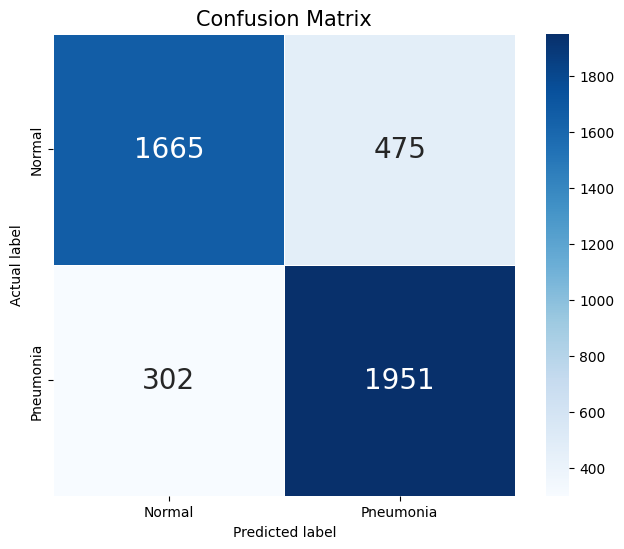

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predictions, class_names):
    """
    This function plots the confusion matrix.

    Parameters:
    - true_labels: The ground truth labels.
    - predictions: The predicted labels by the model.
    - class_names: A list of class names, in the order they index the matrix.
    """
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', annot_kws={"size": 20},
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix', size = 15)
    plt.show()

plot_confusion_matrix(true_labels, binary_predictions, ['Normal', 'Pneumonia'])

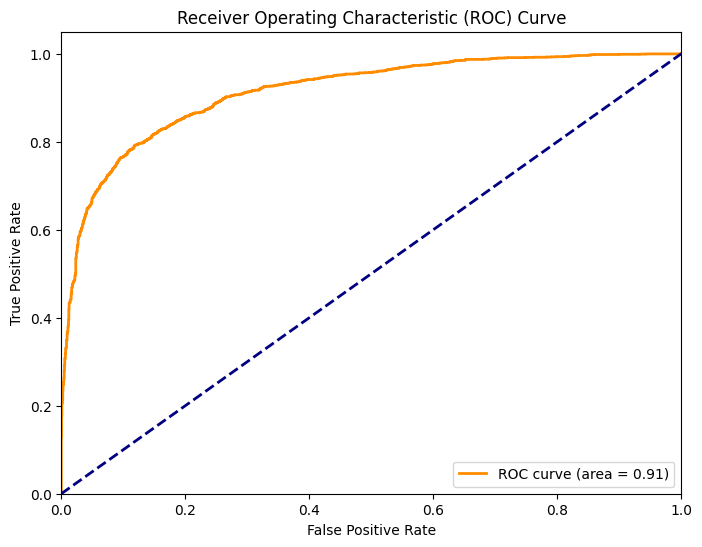

In [14]:
def plot_roc_curve(true_labels, predictions):
    """
    This function plots the ROC curve and shows the AUC score.

    Parameters:
    - true_labels: The ground truth binary labels.
    - predictions: The raw output probabilities from the model for the positive class.
    """
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
plot_roc_curve(true_labels, predictions.ravel())

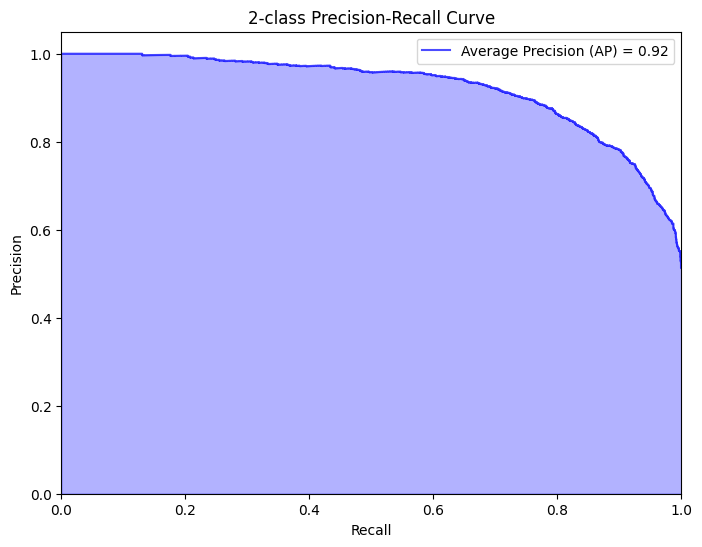

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(true_labels, predictions):
    """
    This function plots the Precision-Recall Curve.

    Parameters:
    - true_labels: Ground truth binary labels.
    - predictions: Predicted probabilities for the positive class.
    """
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    average_precision = average_precision_score(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, where='post', color='b', alpha=0.7, label=f'Average Precision (AP) = {average_precision:.2f}')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()
plot_precision_recall_curve(true_labels, predictions)

In [16]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_training_history(history)


NameError: name 'history' is not defined